In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
wget https://raw.githubusercontent.com/guiwitz/BIAPy/master/course_functions.py

# 7. Functions

In the previous chapter we developped a small procedure to segment our image of nuclei. If you develop such a routine you are going to re-use it multiple times, so it makes sense to package it into a re-usable unit. In particular you should really avoid to:1
1. Copy the same code over and over across notebooks
2. End-up with gigantic notebooks that contain your entire code

We will summarize here how to package our small routine into a .py file that we can re-use. The next step would be to create an installable module but this is beyond the scope of this course.

In [1]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
plt.gray();

import skimage.io
import skimage.morphology
import skimage.filters

<Figure size 432x288 with 0 Axes>

In [2]:
#load the image to process
data = skimage.io.MultiImage('/content/drive/My Drive/Data/30567/30567.tif')
image = data[3]

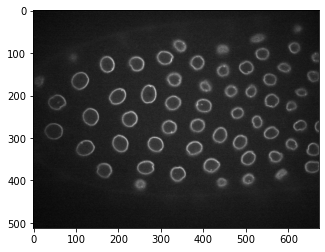

In [3]:
plt.imshow(image);

Let us summarize all the necessary steps within one code block

In [4]:
from skimage.measure import label, regionprops_table

# filtering
image = skimage.filters.median(image,selem=np.ones((2,2)))
# local thresholding
image_local_threshold = skimage.filters.threshold_local(image,block_size=51)
image_local = image > image_local_threshold
# remove tiny features
image_local_open = skimage.morphology.binary_opening(image_local, selem=skimage.morphology.disk(2))
# label image
image_labeled = label(image_local_open)
# analyze regions
our_regions = regionprops_table(image_labeled, properties = ('label','area','coords'))
# create a new mask with constraints on the regions to keep
newimage = np.zeros(image.shape)
# fill in using region coordinates
for x in range(len(our_regions['area'])):
    if our_regions['area'][x]>300:
        newimage[our_regions['coords'][x][:,0],our_regions['coords'][x][:,1]] = 1

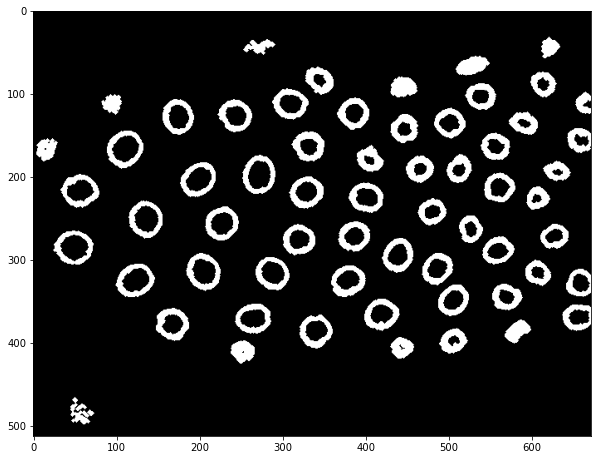

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(newimage);

We can now make a function out of it. You can choose the "level" of your function depending on your needs. For example you could pass a filename and a plane index to the function and make it import your data, or you can pass directly an image.

In addition to the image, you coud pass other arguments if you want to make your function more general. For example, you might not always want to filter objects of the same size or shape, and so you can set those as parameters:

In [6]:
from skimage.measure import label, regionprops

def detect_nuclei(image, size = 200):
    
    # filtering
    image = skimage.filters.median(image,selem=np.ones((2,2)))
    # local thresholding
    image_local_threshold = skimage.filters.threshold_local(image,block_size=51)
    image_local = image > image_local_threshold
    # remove tiny features
    image_local_open = skimage.morphology.binary_opening(image_local, selem=skimage.morphology.disk(2))
    # label image
    image_labeled = label(image_local_open)
    # analyze regions
    our_regions = regionprops_table(image_labeled, properties = ('label','area','coords'))
    # create a new mask with constraints on the regions to keep
    newimage = np.zeros(image.shape)
    # fill in using region coordinates
    for x in range(len(our_regions['area'])):
        if our_regions['area'][x] > size:
            newimage[our_regions['coords'][x][:,0],our_regions['coords'][x][:,1]] = 1
            
    return newimage

And now we can test the function (which appears also now in autocompletion):

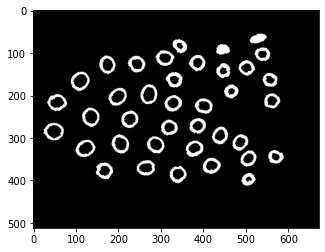

In [7]:
image = data[3]
nuclei = detect_nuclei(image, size = 600)
plt.imshow(nuclei);

In order to avoid cluttering your notebooks with function definitions and to be able to reuse your functions across multiple notebooks, I also strongly advise you to create your own module files. Those are .py files that group multipe functions and that can be called from any notebook.

Let's create one, call it my_module.py and copy our function in it. Now we can use the function like this:

In [9]:
import my_module
#or alternatively: from my_module import detect_nuclei

In [10]:
nuclei2 = my_module.detect_nuclei(image)

Depending what you copied in the .py file you might get error messages about inexistant packages. Indeed in the function we use several modules and we have to make sure we are importing them directly in the .py file to be usable. In case you correct the .py file, restart the kernel as re-loading a module doesn't work.

We can finally apply our function on any plane of the complete stack:

In [14]:
image = data[12]

import my_module
nuclei2 = my_module.detect_nuclei(image)

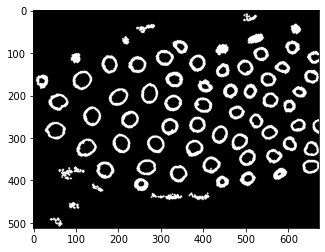

In [15]:
plt.imshow(nuclei2);

Your own modules are accessible if they are in the same folder as your notebook or on some path recognized by Python (on the PYTHONPATH). For more details see [here](https://docs.python.org/3.3/tutorial/modules.html).